<h1><center>Eye For Blind</center></h1>
<h5><center>Objective:</center></h5>
<h6><center>To create a deep learning model that can explain the content of an image in the form of speech through caption generation.</center></h6>
<center>By:</center>
<center>Peter Sharun Woodman M</center>

In [ ]:
#Import all the required libraries

import os

from google.colab import drive # Comment this if you are not running the notebook in google colab

import matplotlib.pyplot as plt

from matplotlib.pyplot import imread

from skimage.transform import resize

from PIL import Image

import glob

import pandas as pd
pd.set_option("display.max_colwidth", None)

import numpy as np

import io

from collections import Counter

import itertools

from keras.applications.inception_v3 import preprocess_input

import tensorflow as tf

import collections

import random

from tensorflow.keras import layers, Model 

from tqdm import tqdm

import time

from gtts import gTTS

from IPython import display

Let's read the dataset

## Data understanding
1.Import the dataset and read image & captions into two seperate variables

2.Visualise both the images & text present in the dataset

3.Create word-to-index and index-to-word mappings.

4.Create a dataframe which summarizes the image, path & captions as a dataframe

5.Visualise the top 30 occuring words in the captions

6.Create a list which contains all the captions & path


In [ ]:
# For mounting and reading file from google colab
# Comment this cell if you are not running this notebook in google colab
drive.mount('/content/gdrive')
!ls "/content/gdrive/My Drive/Colab Notebooks/Upgrad/Capstone Project/archive"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
captions.txt  checkpoints  Images


In [ ]:
#Import the dataset and read the image into a seperate variable

# Setting the root path of the dataset
root_path = "/content/gdrive/My Drive/Colab Notebooks/Upgrad/Capstone Project/archive" # Comment this if you are not running the notebook in google colab
# root_path = "./Flickr8K" # Use this to specify root path when you are not running this notebook in google colab

# Note: Please keep the files to read in the same directory as the current python file
images = root_path + '/Images'

all_imgs = glob.glob(images + '/*.jpg', recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs)))

The total images present in the dataset: 8091


Visualise the images & text present in the dataset: 

Captions for Image: 

36690                   A black dog chases a ball in the grass .
36691           A black dog is chasing a ball on a green grass .
36692    A dog and a ball on green grass and in front of trees .
36693                         A dog chases a ball in the grass .
36694     Green grass field , a black dog running after a ball .
Name: caption, dtype: object

Image: 


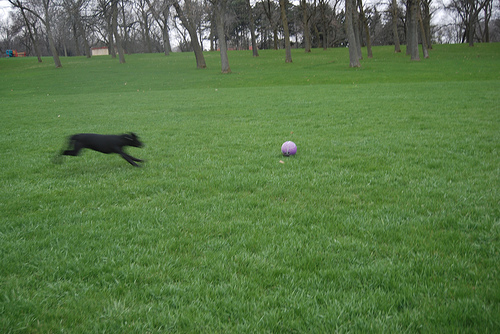

In [ ]:
#Visualise both the images & text present in the dataset
print("Visualise the images & text present in the dataset: \n")

# Printing the captions for a image
captions_df = pd.read_csv(root_path+'/captions.txt')
print("Captions for Image: ", end="\n\n")
print(captions_df[captions_df["image"] == all_imgs[200].split("/")[-1]]["caption"], end="\n\n")

# Displaying the image
print("Image: ")
Image.open(all_imgs[200])

In [ ]:
#Import the dataset and read the text file into a seperate variable

def load_doc(filename):
    
    #your code here
    df_cap = pd.read_csv(filename)
    return df_cap

text_file = root_path + '/captions.txt'
doc = load_doc(text_file)
print(doc[:300])

                         image                                                                                                                   caption
0    1000268201_693b08cb0e.jpg                                                  A child in a pink dress is climbing up a set of stairs in an entry way .
1    1000268201_693b08cb0e.jpg                                                                                     A girl going into a wooden building .
2    1000268201_693b08cb0e.jpg                                                                          A little girl climbing into a wooden playhouse .
3    1000268201_693b08cb0e.jpg                                                                      A little girl climbing the stairs to her playhouse .
4    1000268201_693b08cb0e.jpg                                                                 A little girl in a pink dress going into a wooden cabin .
..                         ...                                                    

Create a dataframe which summarizes the image, path & captions as a dataframe

Each image id has 5 captions associated with it therefore the total dataset should have 40455 samples.

In [ ]:
def get_all_image_id():
    return list(doc["image"].str.replace(".jpg", ""))

def get_all_img_vector(all_img_id_param):
    return [(images + '/' + ele +'.jpg') for ele in all_img_id]

def get_annotations():
    return list(doc["caption"])

all_img_id= get_all_image_id() #store all the image id here
all_img_vector= get_all_img_vector(all_img_id) #store all the image path here
annotations= get_annotations() #store all the captions here

df = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns =['ID','Path', 'Captions']) 
    
df

,ID,Path,Captions
0,1000268201_693b08cb0e,/content/gdrive/My Drive/Colab Notebooks/Upgrad/Capstone Project/archive/Images/1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1,1000268201_693b08cb0e,/content/gdrive/My Drive/Colab Notebooks/Upgrad/Capstone Project/archive/Images/1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e,/content/gdrive/My Drive/Colab Notebooks/Upgrad/Capstone Project/archive/Images/1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e,/content/gdrive/My Drive/Colab Notebooks/Upgrad/Capstone Project/archive/Images/1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .
4,1000268201_693b08cb0e,/content/gdrive/My Drive/Colab Notebooks/Upgrad/Capstone Project/archive/Images/1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .
...,...,...,...
40450,997722733_0cb5439472,/content/gdrive/My Drive/Colab Notebooks/Upgrad/Capstone Project/archive/Images/997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face
40451,997722733_0cb5439472,/content/gdrive/My Drive/Colab Notebooks/Upgrad/Capstone Project/archive/Images/997722733_0cb5439472.jpg,A man is rock climbing high in the air .
40452,997722733_0cb5439472,/content/gdrive/My Drive/Colab Notebooks/Upgrad/Capstone Project/archive/Images/997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock face covered in assist handles .
40453,997722733_0cb5439472,/content/gdrive/My Drive/Colab Notebooks/Upgrad/Capstone Project/archive/Images/997722733_0cb5439472.jpg,A rock climber in a red shirt .


In [ ]:
#Create the vocabulary & the counter for the captions

# Function to convert the sentence list to word list
def sent_list_to_word_list(sent_list):
    join_str = " ".join(sent_list)
    return join_str.split(" ")

# Create the vocabulary for the captions
vocabulary= sent_list_to_word_list(df["Captions"])

# Create the counter for the captions
val_count=Counter(vocabulary)
val_count

Counter({'A': 22667,
         'child': 1477,
         'in': 18962,
         'a': 40319,
         'pink': 734,
         'dress': 348,
         'is': 9345,
         'climbing': 502,
         'up': 1260,
         'set': 108,
         'of': 6712,
         'stairs': 109,
         'an': 1945,
         'entry': 1,
         'way': 50,
         '.': 36577,
         'girl': 3218,
         'going': 149,
         'into': 1074,
         'wooden': 284,
         'building': 510,
         'little': 1625,
         'playhouse': 6,
         'the': 15328,
         'to': 3173,
         'her': 1178,
         'cabin': 4,
         'black': 3696,
         'dog': 7984,
         'and': 8850,
         'spotted': 37,
         'are': 3503,
         'fighting': 132,
         'tri-colored': 14,
         'playing': 2008,
         'with': 7760,
         'each': 430,
         'other': 772,
         'on': 10730,
         'road': 388,
         'white': 3876,
         'brown': 2475,
         'spots': 29,
         'staring'

Visualizing the top 30 occuring words:



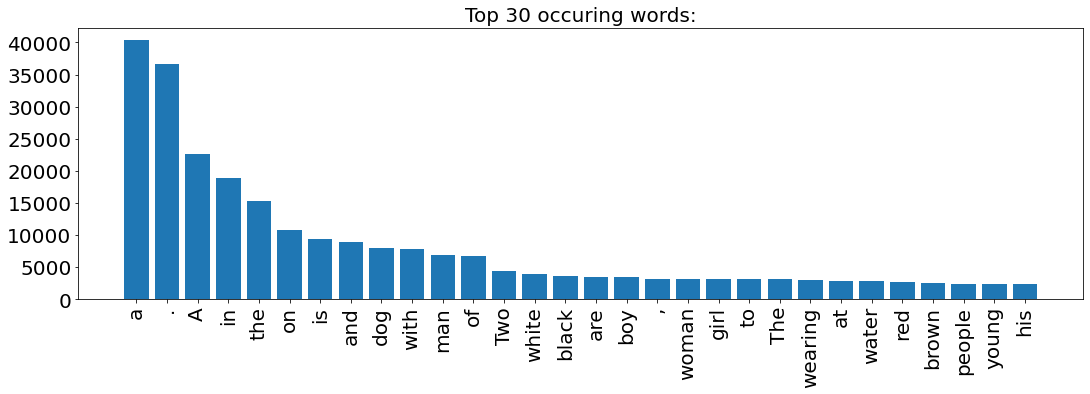

In [ ]:
#Visualise the top 30 occuring words in the captions

common_word_count_30 = val_count.most_common(30)

# Extract the first element from nested list
def extract_first(lst):
    return [item[0] for item in lst]

# Extract the second element from nested list
def extract_second(lst):
    return [item[1] for item in lst]

ext_words_30 = extract_first(common_word_count_30)

ext_count_30 = extract_second(common_word_count_30)

print("Visualizing the top 30 occuring words:\n")
plt.figure(figsize=(18,5))
plt.bar(ext_words_30, ext_count_30)
plt.yticks(fontsize=20)
plt.xticks(ext_words_30, rotation=90,fontsize=20)
plt.title("Top 30 occuring words:",fontsize=20)
plt.show()

In [ ]:
#Create a list which contains all the captions

annotations= df['Captions'] 

#add the <start> & <end> token to all those captions as well

# Function to add the start and end token
def get_annot_startend_token(annotations):
    return '<start> ' + annotations.astype(str) + ' <end>'

annotations= get_annot_startend_token(annotations)

#Create a list which contains all the path to the images
all_img_path= all_imgs 

print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_img_path)))

Total captions present in the dataset: 40455
Total images present in the dataset: 8091


## Pre-Processing the captions
1.Create the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters. 
This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.

2.Replace all other words with the unknown token "UNK" .

3.Create word-to-index and index-to-word mappings.

4.Pad all sequences to be the same length as the longest one.

In [ ]:
# create the tokenizer

#your code here
num_words = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=num_words,
                                                  oov_token="UNK",
                                                  filters='.!"#$%&()*+,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(annotations)

# Set the word to index and index to word mapping for padding.
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

# Creating the tokenized vectors
tokenized_vector = tokenizer.texts_to_sequences(annotations)

In [ ]:
# Create word-to-index and index-to-word mappings.

#your code here

word_to_index = tokenizer.word_index
index_to_word = tokenizer.index_word

In [ ]:
# Create a word count of your tokenizer to visulize the Top 30 occuring words after text processing

# Creating the word count for the tokenizer
tokenizer_word_counts = tokenizer.word_counts

# Printing the top 30 occuring words
(Counter(tokenizer_word_counts).most_common(30))

[('a', 62992),
 ('<start>', 40455),
 ('<end>', 40455),
 ('in', 18986),
 ('the', 18419),
 ('on', 10745),
 ('is', 9345),
 ('and', 8862),
 ('dog', 8138),
 ('with', 7765),
 ('man', 7274),
 ('of', 6723),
 ('two', 5642),
 ('white', 3959),
 ('black', 3848),
 ('boy', 3581),
 ('are', 3504),
 ('woman', 3402),
 ('girl', 3328),
 ('to', 3176),
 ('wearing', 3062),
 ('at', 2915),
 ('people', 2883),
 ('water', 2790),
 ('red', 2691),
 ('young', 2630),
 ('brown', 2578),
 ('an', 2432),
 ('his', 2357),
 ('blue', 2279)]

In [ ]:
# Pad each vector to the max_length of the captions ^ store it to a vairable

# Padding each vector to max_length
cap_vector=  tf.keras.preprocessing.sequence.pad_sequences(tokenized_vector, padding='post') #your code here

# Printing the shape of caption vector
print("The shape of Caption vector is :" + str(cap_vector.shape))

The shape of Caption vector is :(40455, 39)


## Pre-processing the images

1.Resize them into the shape of (299, 299)

3.Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3. 

In [ ]:

# Function to read, resize and normalize the image.
def resize_norm_image(image_path):

    # Read the image
    image_read = tf.io.read_file(image_path)

    # Decode the jpeg into 3 channels
    image_read = tf.image.decode_jpeg(image_read, channels=3)

    # Resize the image into the shape of (299, 299)
    image_resized = tf.image.resize(image_read, (299, 299))

    # Normalize the image using the preprocess_input method
    image_rs_norm = tf.keras.applications.inception_v3.preprocess_input(image_resized)

    return image_rs_norm, image_path

## Create the train & test data 
1.Combine both images & captions to create the train & test dataset using tf.data.Dataset API. Create the train-test spliit using 80-20 ratio & random state = 42

2.Make sure you have done Shuffle and batch while building the dataset

3.The shape of each image in the dataset after building should be (batch_size, 299, 299, 3)

4.The shape of each caption in the dataset after building should be(batch_size, max_len)


In [ ]:

# Combining the images and captions
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(df["Path"], cap_vector):
    img_to_cap_vector[img].append(cap)

# Extract the image keys and shuffle it with random state as 42
img_keys = list(img_to_cap_vector.keys())
random.Random(42).shuffle(img_keys)

# Splitting the data into train and test using 80-20 ratio
slice_index = int(len(img_keys)*0.8)
img_train_keys, img_test_keys = img_keys[:slice_index], img_keys[slice_index:]

# Extract the image paths and captions for train dataset
img_train = []
cap_train = []
for imgt in img_train_keys:
    capt_len = len(img_to_cap_vector[imgt])
    img_train.extend([imgt] * capt_len)
    cap_train.extend(img_to_cap_vector[imgt])

# Extract the image paths and captions for test dataset
img_test = []
cap_test = []
for imgv in img_test_keys:
    capt_len = len(img_to_cap_vector[imgv])
    img_test.extend([imgv] * capt_len)
    cap_test.extend(img_to_cap_vector[imgv])

# Set the batch size and buffer size
BATCH_SIZE = 64
BUFFER_SIZE = 1000

# Function to read the image
def get_extimage_caption(img_name, cap):
    ext_image, img_path = resize_norm_image(img_name.decode('utf-8'))
    return ext_image, cap

# Create the tf dataset for training data
train_dataset = tf.data.Dataset.from_tensor_slices((img_train, cap_train))

# Using map to apply the extract function for the tensor data
train_dataset = train_dataset.map(lambda item1, item2: tf.numpy_function(
          get_extimage_caption, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle the tf dataset and perform batching
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

# Create the tf dataset for testing data
test_dataset = tf.data.Dataset.from_tensor_slices((img_test, cap_test))

# Using map to apply the extract function for the tensor data
test_dataset = test_dataset.map(lambda item1, item2: tf.numpy_function(
          get_extimage_caption, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle the tf dataset and perform batching
test_dataset = test_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape) #(batch_size, 299, 299, 3)
print(sample_cap_batch.shape) #(batch_size, max_len)

(64, 299, 299, 3)
(64, 39)


## Load the pretrained Imagenet weights of Inception net V3

1.To save the memory(RAM) from getting exhausted, extract the features of thei mage using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

2.The shape of the output of this layer is 8x8x2048. 

3.Use a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048)



In [ ]:
image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

new_input = image_model.input #write code here to get the input of the image_model
hidden_layer = image_model.layers[-1].output #write code here to get the output of the image_model

image_features_extract_model = tf.keras.Model(new_input, hidden_layer) #build the final model using both input & output layer

87916544/87910968 [==============================] - 1s 0us/step


In [ ]:
# Extract features from each image in the dataset

path_feature_dic = {};

# Function to extract the features using pretrained imagenet weights of InceptionV3
def exract_features_tensor(img_path):

    # Removing the duplicates to eliminate redundancy in extraction
    unique_img = sorted(set(img_path))

    # Creating a tf dataset for the unique images and map the image prepreocessing
    image_dataset = tf.data.Dataset.from_tensor_slices(unique_img)
    image_dataset = image_dataset.map(
    resize_norm_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(BATCH_SIZE)
    image_dataset = image_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    # Iterate over the dataset and extract features using InceptionV3
    for img, path in tqdm(image_dataset):
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features,
                                (batch_features.shape[0], -1, batch_features.shape[3]))

        # Iterate over the batch features and path
        for bf, p in zip(batch_features, path):
            path_of_feature = p.numpy().decode("utf-8")

            # Save the extracted features in a dictionary.
            path_feature_dic[path_of_feature] = bf


# Extract the features using InceptionV3 for train dataset
print("Extracting the features for train data: ")
exract_features_tensor(img_train)

# Function to map the jpg image path to dictionary
def map_to_npy(img_name, cap):
    img_tensor = path_feature_dic[img_name.decode('utf-8')]
    return img_tensor, cap

# Update the tf dataset for training data to the dictionary
train_dataset = tf.data.Dataset.from_tensor_slices((img_train, cap_train))
train_dataset = train_dataset.map(lambda item1, item2: tf.numpy_function(
          map_to_npy, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle the tf dataset and perform batching
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

# Prefetch the dataset to improve performance
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Extract the features using InceptionV3 for test dataset
print("Extracting the features for test data: ")
exract_features_tensor(img_test)

# Update the tf dataset for training data to the dictionary
test_dataset = tf.data.Dataset.from_tensor_slices((img_test, cap_test))
test_dataset = test_dataset.map(lambda item1, item2: tf.numpy_function(
          map_to_npy, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle the tf dataset and perform batching
test_dataset = test_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

# Prefetch the dataset to improve performance
test_dataset = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

  0%|          | 0/102 [00:00<?, ?it/s]

Extracting the features for train data: 


  0%|          | 0/26 [00:00<?, ?it/s]

Extracting the features for test data: 


100%|██████████| 26/26 [02:56<00:00,  6.77s/it]


In [ ]:
# Iterate once in train_dataset to verify the shape
sample_img_batch, sample_cap_batch = next(iter(train_dataset))

# Print the shapes of image and caption from the iterated train_dataset
print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,40)

(64, 64, 2048)
(64, 39)


## Model Building
1.Set the parameters

2.Build the Encoder, Attention model & Decoder

In [ ]:
# Set the parameters

embedding_dim = 256 
units = 512
vocab_size = num_words + 1 #top 5,000 words +1
train_num_steps = len(img_train) // BATCH_SIZE #len(total train images) // BATCH_SIZE
test_num_steps = len(img_test) // BATCH_SIZE #len(total test images) // BATCH_SIZE
max_length = len(cap_train[0])
attention_features_shape = 64 

### Encoder

In [ ]:
# Building the encoder

class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.dense = tf.keras.layers.Dense(embed_dim, activation='relu') #build your Dense layer with relu activation
        
    def call(self, features):
        features =  self.dense(features) # extract the features from the image shape: (batch, 8*8, embed_dim)
        
        return features

In [ ]:
# Initialize the encoder

encoder=Encoder(embedding_dim)

### Attention model

In [ ]:
# Build the attention model

class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = tf.keras.layers.Dense(units) #build your Dense layer
        self.W2 = tf.keras.layers.Dense(units) #build your Dense layer
        self.V = tf.keras.layers.Dense(1) #build your final Dense layer with unit 1
        self.units=units

    def call(self, features, hidden):
        #features shape: (batch_size, 8*8, embedding_dim)
        # hidden shape: (batch_size, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1) # Expand the hidden shape to shape: (batch_size, 1, hidden_size)
        score = self.V((tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis)))) # build your score funciton to shape: (batch_size, 8*8, units)
        attention_weights = tf.nn.softmax(score, axis=1) # extract your attention weights with shape: (batch_size, 8*8, 1)
        context_vector = attention_weights * features #shape: create the context vector with shape (batch_size, 8*8,embedding_dim)
        context_vector = tf.reduce_sum(context_vector, axis=1) # reduce the shape to (batch_size, embedding_dim)
        
        return context_vector, attention_weights

### Decoder

In [ ]:
# Build the decoder

class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(self.units) #iniitalise your Attention model with units
        self.embed = tf.keras.layers.Embedding(vocab_size, embed_dim) #build your Embedding layer
        self.gru = tf.keras.layers.GRU(self.units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')
        self.d1 = tf.keras.layers.Dense(self.units) #build your Dense layer
        self.d2 = tf.keras.layers.Dense(vocab_size) #build your Dense layer
        

    def call(self,x,features, hidden):
        context_vector, attention_weights = self.attention(features, hidden) #create your context vector & attention weights from attention model
        embed = self.embed(x) # embed your input to shape: (batch_size, 1, embedding_dim)
        embed = tf.concat([tf.expand_dims(context_vector, 1), embed], axis=-1) # Concatenate your input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
        output,state = self.gru(embed) # Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) # shape : (batch_size * max_length, hidden_size)
        output = self.d2(output) # shape : (batch_size * max_length, vocab_size)
        
        return output,state, attention_weights
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [ ]:
# Initialize the decoder

decoder=Decoder(embedding_dim, units, vocab_size)

In [ ]:
# Extract the features using encoder
features=encoder(sample_img_batch)

# Prepare the inputs for decoder
hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

# Pass the inputs to the decoder
predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

Feature shape from Encoder: (64, 64, 256)
Predcitions shape from Decoder: (64, 5001)
Attention weights shape from Decoder: (64, 64, 1)


## Model training & optimization
1.Set the optimizer & loss object

2.Create your checkpoint path

3.Create your training & testing step functions

4.Create your loss function for the test dataset

In [ ]:
optimizer = tf.keras.optimizers.Adam() #define the optimizer
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none') #define your loss object

In [ ]:
# Define the loss function
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [ ]:
# Setting up the checkpoint using checkpoint manager
checkpoint_path = root_path + "/checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [ ]:
# Restore the latest checkpoint
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

In [ ]:
# Define the function for train step
@tf.function
def train_step(img_tensor, target):
    loss = 0

    # Prepare the inputs for the decoder
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        # Training steps

        # Extract the features using the encoder
        features = encoder(img_tensor)

        # Iterate for length of caption times
        for i in range(1, target.shape[1]):

            # Pass the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            # Calculate the loss using the loss function
            loss += loss_function(target[:, i], predictions)

            # Shift to next word in target caption (teacher forcing)
            dec_input = tf.expand_dims(target[:, i], 1)

    # Calculate average loss
    avg_loss = (loss / int(target.shape[1]))

    # Combine the encoder and decoder trainable variables
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    # Process the gradrients from the loss
    gradients = tape.gradient(loss, trainable_variables)

    # Use the gradients to update the trainable variables
    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, avg_loss

In [ ]:
# Define the function for test step
@tf.function
def test_step(img_tensor, target):
    loss = 0
    
    #Testing steps
      
    # Prepare the inputs for the decoder
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    # Extract the features using the encoder
    features = encoder(img_tensor)

    # Iterate for length of caption times
    for i in range(1, target.shape[1]):

        # Pass the features through the decoder
        predictions, hidden, _ = decoder(dec_input, features, hidden)

        # Calculate the loss using the loss function
        loss += loss_function(target[:, i], predictions)

        # Extract the embeding which carries the maximum value
        dec_input = tf.expand_dims(tf.math.argmax(predictions, axis=1), 1)

    # Calculate the average loss
    avg_loss = (loss / int(target.shape[1]))

    return loss, avg_loss

In [ ]:
# Define the function to calculate test loss
def test_loss_cal(test_dataset):
    total_loss = 0

    #Get the average loss result on your test data

    # Iterate over the test dataset
    for (batch, (img_tensor, target)) in enumerate(test_dataset):

        # Calculate batch loss and average loss
        batch_loss, t_loss = test_step(img_tensor, target)

        # Calculate the total loss
        total_loss += t_loss

        # Calcuate the average loss
        avg_test_loss = total_loss / test_num_steps

    return avg_test_loss

In [ ]:
loss_plot = []
test_loss_plot = []
EPOCHS = 15

best_test_loss=100

# Iterate over the epochs
for epoch in range(0, EPOCHS):

    # Start the timer
    start = time.time()
    total_loss = 0

    # Iterate over the train dataset
    for (batch, (img_tensor, target)) in tqdm(enumerate(train_dataset)):
        # Calculate the batch loss and average loss
        batch_loss, t_loss = train_step(img_tensor, target)

        # Calculate the total loss
        total_loss += t_loss

        # Calculate the average train loss
        avg_train_loss=total_loss / train_num_steps

    # Append the average train loss to a list
    loss_plot.append(avg_train_loss)

    # Calculate the test loss
    test_loss = test_loss_cal(test_dataset)

    # Append the average test loss to a list
    test_loss_plot.append(test_loss)

    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

    # If the test loss is better then take a checkpoint save
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

505it [01:57,  4.28it/s]


For epoch: 1, the train loss is 1.273, & test loss is 1.984
Time taken for 1 epoch 141.04653692245483 sec

Test loss has been reduced from 100.000 to 1.984


505it [01:15,  6.70it/s]


For epoch: 2, the train loss is 0.988, & test loss is 1.901
Time taken for 1 epoch 85.91358017921448 sec

Test loss has been reduced from 1.984 to 1.901


505it [01:14,  6.75it/s]
0it [00:00, ?it/s]

For epoch: 3, the train loss is 0.893, & test loss is 1.952
Time taken for 1 epoch 85.28754591941833 sec



505it [01:15,  6.72it/s]
0it [00:00, ?it/s]

For epoch: 4, the train loss is 0.827, & test loss is 1.979
Time taken for 1 epoch 85.64078569412231 sec



505it [01:14,  6.74it/s]
0it [00:00, ?it/s]

For epoch: 5, the train loss is 0.774, & test loss is 2.015
Time taken for 1 epoch 85.3265700340271 sec



505it [01:15,  6.73it/s]
0it [00:00, ?it/s]

For epoch: 6, the train loss is 0.727, & test loss is 2.122
Time taken for 1 epoch 85.50186848640442 sec



505it [01:14,  6.74it/s]
0it [00:00, ?it/s]

For epoch: 7, the train loss is 0.687, & test loss is 2.167
Time taken for 1 epoch 85.43044972419739 sec



505it [01:14,  6.76it/s]
0it [00:00, ?it/s]

For epoch: 8, the train loss is 0.650, & test loss is 2.147
Time taken for 1 epoch 85.21634697914124 sec



505it [01:14,  6.75it/s]
0it [00:00, ?it/s]

For epoch: 9, the train loss is 0.615, & test loss is 2.209
Time taken for 1 epoch 85.24553227424622 sec



505it [01:14,  6.74it/s]
0it [00:00, ?it/s]

For epoch: 10, the train loss is 0.583, & test loss is 2.307
Time taken for 1 epoch 85.38532662391663 sec



505it [01:14,  6.75it/s]
0it [00:00, ?it/s]

For epoch: 11, the train loss is 0.553, & test loss is 2.329
Time taken for 1 epoch 85.26862502098083 sec



505it [01:14,  6.74it/s]
0it [00:00, ?it/s]

For epoch: 12, the train loss is 0.525, & test loss is 2.417
Time taken for 1 epoch 85.42993712425232 sec



505it [01:14,  6.74it/s]
0it [00:00, ?it/s]

For epoch: 13, the train loss is 0.500, & test loss is 2.459
Time taken for 1 epoch 85.39405560493469 sec



505it [01:14,  6.74it/s]
0it [00:00, ?it/s]

For epoch: 14, the train loss is 0.476, & test loss is 2.535
Time taken for 1 epoch 85.32403635978699 sec



505it [01:15,  6.73it/s]


For epoch: 15, the train loss is 0.453, & test loss is 2.592
Time taken for 1 epoch 85.42624545097351 sec



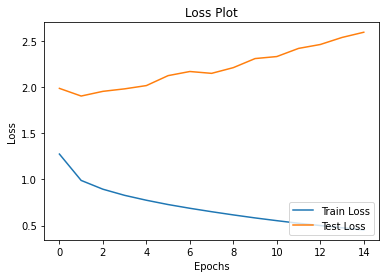

Observation:
- We can observe that the train loss is reducing over subsequent epochs.
- The test loss is reducing for the first 3 epochs but for the remaining epochs it is increasing.
- This trend of reducing training loss and increasing test loss shows that the model is overfitting.
- This can be resolved by using overfitting techniques like dropouts, regularization etc.
- We can also train with more data by using larger datasets such as MS COCO and Flickr30k dataset.


In [ ]:
# Plot the loss for train and test data
plt.plot(loss_plot)
plt.plot(test_loss_plot)

# Set the label and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')

# Set the legends
plt.legend(["Train Loss", "Test Loss"], loc ="lower right")

plt.show()

print("\nObservation:")
print("- We can observe that the train loss is reducing over subsequent epochs.")
print("- The test loss is reducing for the first 3 epochs but for the remaining epochs it is increasing.")
print("- This trend of reducing training loss and increasing test loss shows that the model is overfitting.")
print("- This can be resolved by using overfitting techniques like dropouts, regularization etc.")
print("- We can also train with more data by using larger datasets such as MS COCO and Flickr30k dataset.")

## Model Evaluation
1.Define your evaluation function using greedy search

2.Define your evaluation function using beam search ( optional)

3.Test it on a sample data using BLEU score

### Greedy Search

In [ ]:
# Function to evaluate model using greedy search
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    # Initialize the hidden state
    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(resize_norm_image(image)[0], 0) #process the input image to desired format before extracting features

    img_tensor_val = image_features_extract_model(temp_input) # Extract features using our feature extraction model
    
    # Reshape the tensor
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val) # extract the features by passing the input to encoder

    # Prepare the inputs for decoder
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    # Iterate over the max length of captions
    for i in range(max_length):

        predictions, hidden, attention_weights = decoder(dec_input, features, hidden) # get the output from decoder

        # Reshape the attention weights
        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = np.argmax(predictions[0]) #extract the predicted id(embedded value) which carries the max value
        
        #map the id to the word from tokenizer and append the value to the result list
        result.append(tokenizer.index_word[predicted_id])

        # If the end token is reached return response
        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        # Shift to next word in input caption
        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot, predictions


### Beam Search(optional)

In [ ]:
def beam_evaluate(image, beam_index = #your value for beam index):

    #To evaluate the result using beam search
                  
    return final_caption



In [ ]:
# Function to plot the attention map
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))

    # Open the image
    temp_img = np.array(Image.open(image))

    len_cap = len(caption)

    # Iterate over the caption length
    for cap in range(len_cap):

        # Transform the weights 
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))

        # Set subplot params and title
        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)

        img=ax.imshow(temp_img)

        # Set the attention weights over image
        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
        
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [ ]:
from nltk.translate.bleu_score import sentence_bleu

In [ ]:
# Function to filter out the start, end and unknown tokens
def filt_text(text):
    filt=['<start>','<unk>','<end>', 'UNK'] # Adding the UNK term, as we have initialized the OOV token as UNK
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


BELU score: 56.23413251903491
Real Caption: a person on a motorcycle
Prediction Caption: a motorcycle rider in a race


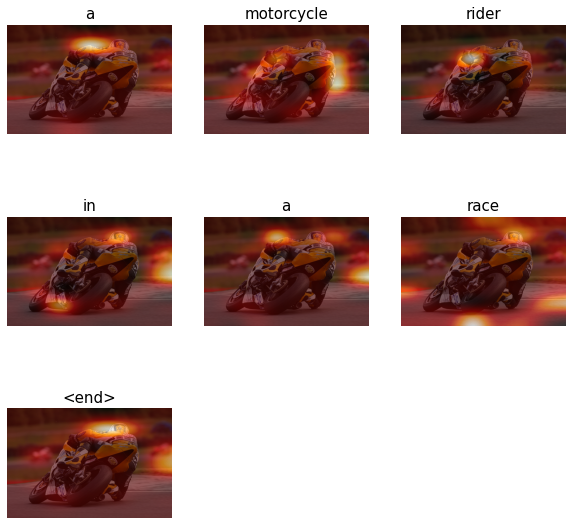

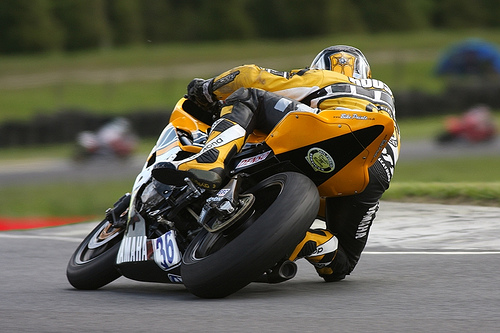

In [ ]:
# Select a random image from the test dataset
rid = np.random.randint(0, len(img_test))
test_image = img_test[rid]
#test_image = './images/413231421_43833a11f5.jpg'
#real_caption = '<start> black dog is digging in the snow <end>'

# Extract the real caption
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test[rid] if i not in [0]])

# Pass the test image to the evaluate function
result, attention_plot,pred_test = evaluate(test_image)

# Filter the real caption using the filter function
real_caption=filt_text(real_caption)      

# Preparing the predicted caption
pred_caption=' '.join(result).rsplit(' ', 1)[0]

# Preparing data for finding bleu score
real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

# Calculating the bleu score
score = sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25))
print(f"BELU score: {score*100}")

# Printing and visualizing
print('Real Caption:', real_caption)
print('Prediction Caption:', pred_caption)
plot_attmap(result, attention_plot, test_image)

# Open the image
Image.open(test_image)

In [ ]:
captions=beam_evaluate(test_image)
print(captions)

### Text to speech 
##### Note: The below audio can be played without running the notebook in Google Colab

In [ ]:
print("Converting the predicted caption to audio...\n\n")

# Initiliaze google text to speech with the predicted caption
tts = gTTS(pred_caption, slow=False)

# Save as an audio file
tts.save('pred_caption_audio.mp3')

# Display for playing the audio
print("Conversion completed. Please cick on the play button.\n")
sound_file = 'pred_caption_audio.mp3'
display.display(display.Audio(sound_file))

Converting the predicted caption to text...


Conversion completed. Please cick on the play button.

